# Compare performance of EQLHarmonicBoost with different overlapping

**Import useful packages**

In [1]:
from pathlib import Path
import time
import numpy as np
import pandas as pd
import xarray as xr
import harmonica as hm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from boost_and_layouts import (
    block_averaged_sources,
    combine_parameters,
    EQLHarmonicBoost,
    save_to_json,
)


**Define results directory**

In [2]:
results_dir = Path("..") / "results"
airborne_results_dir = results_dir / "airborne_survey"
eql_boost_results_dir = results_dir / "eql-boost"

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Define which field will be meassured**

In [3]:
field = "g_z"
field_units = "mGal"

## Read synthetic airborne survey and target grid

Read airborne survey

In [4]:
survey = pd.read_csv(airborne_results_dir / "survey.csv")
survey

,longitude,latitude,height,easting,northing,g_z
0,-0.496429,0.497339,633.0,-55262.223508,54993.627800,3.654625
1,-0.495559,0.497999,644.0,-55165.348426,55066.630053,2.503813
2,-0.493218,0.497479,646.0,-54904.787861,55009.113126,2.873545
3,-0.482725,0.497679,663.0,-53736.719343,55031.235020,3.125810
4,-0.478464,0.497719,672.0,-53262.365493,55035.659399,4.717045
...,...,...,...,...,...,...
5668,-0.416257,0.155824,1070.0,-46337.467390,17230.106636,10.041573
5669,-0.258422,0.271476,1087.0,-28767.445331,30018.377395,15.431621
5670,-0.258652,0.277958,1126.0,-28793.055985,30735.107734,14.078125
5671,-0.258983,0.287360,1106.0,-28829.801706,31774.809862,15.672714


Read target grid

In [5]:
target = xr.open_dataarray(results_dir / "target.nc")
target

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray (northing: 56, easting: 57)>
array([[2.942098, 3.335356, 3.699304, ..., 3.534445, 3.187211, 2.824452],
       [3.334727, 3.805254, 4.23806 , ..., 4.003668, 3.594596, 3.165999],
       [3.697873, 4.237236, 4.731814, ..., 4.442474, 3.976724, 3.488055],
       ...,
       [4.113125, 4.720134, 5.285468, ..., 4.744527, 4.237688, 3.711379],
       [3.717267, 4.247201, 4.740353, ..., 4.301227, 3.852887, 3.387261],
       [3.293559, 3.739541, 4.155882, ..., 3.821831, 3.437721, 3.039456]])
Coordinates:
  * northing  (northing) float64 -5.529e+04 -5.329e+04 ... 5.271e+04 5.471e+04
  * easting   (easting) float64 -5.566e+04 -5.366e+04 ... 5.434e+04 5.634e+04
Attributes:
    height:   2000

Define coordiantes tuple with the location of the survey points

In [6]:
coordinates = (survey.easting.values, survey.northing.values, survey.height.values)

Get region of the target grid

In [7]:
region = (
    target.easting.min().values,
    target.easting.max().values,
    target.northing.min().values,
    target.northing.max().values,
)

# Grid data with EQLHarmonic for reference on performance

Use the best of parameters for block-averaged sources with relative depth, which was obtained on a previous notebook.

In [8]:
depth_type = "relative_depth"
block_spacing = 2e3
damping = 1e-3
depth = 9e3

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grid the data using `hm.EQLHarmonic` and track time of the fitting process

In [9]:
points = block_averaged_sources(
    coordinates, depth_type=depth_type, spacing=block_spacing, depth=depth
)
eql = hm.EQLHarmonic(
    points=points,
    damping=damping,
)

n_runs = 10
times = np.empty(n_runs)
eql.fit(coordinates, getattr(survey, field).values)  # fit to compile Numba functions
for i in range(n_runs):
    start = time.time()
    eql.fit(coordinates, getattr(survey, field).values)
    end = time.time()
    times[i] = end - start

eql_fitting_time = times.mean()

grid = eql.grid(upward=target.height, region=region, shape=target.shape).scalars

Compute RMS of the grid against the target grid and the residue of the gridder (difference between data and predictions on the same observation points)

In [10]:
eql_rms = np.sqrt(mean_squared_error(grid.values, target.values))
diff = survey.g_z - eql.predict((survey.easting, survey.northing, survey.height))
eql_residue = np.sqrt(np.mean(diff ** 2))

print("RMS score: {} mGal".format(eql_rms))
print("Residue: {} mGal".format(eql_residue))
print("Fitting time: {} +/- {} s".format(eql_fitting_time, times.std()))

RMS score: 0.3444410231429399 mGal
Residue: 0.9556175236575818 mGal
Fitting time: 0.45788300037384033 +/- 0.0046931895571244555 s


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Grid data with EQLHarmonicBoost using different overlappings

Define gridding parameters. Use the same depth obtained for EQLHarmonic and a window size of 30km. The damping might be changed to produce similar quality results.

In [11]:
dampings = np.logspace(-3, 1, 5)
window_size = 30e3

# Save window size on a dictionary to save its value to JSON file
variables = {"boost_overlapping_window_size": window_size}

parameters = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depth,
        damping=dampings,
        spacing=block_spacing,
        window_size=window_size,
    )
)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Define overlappings and different random states

In [12]:
overlaps = np.arange(0, 1, 0.05)
random_states = np.arange(10)

Find the best set of parameters for each window size

In [13]:
best_parameters = {}

for overlapping in overlaps:

    # Grid and score the gridders for each combination of parameters
    rms_mean, rms_std = [], []
    residue_mean, residue_std = [], []
    for params in parameters:
        rms = []
        residue = []
        for random_state in random_states:
            points = block_averaged_sources(coordinates, **params)
            eql = EQLHarmonicBoost(
                points=points,
                damping=params["damping"],
                window_size=params["window_size"],
                random_state=random_state,
            )
            eql.overlapping = overlapping
            eql.fit(coordinates, getattr(survey, field).values)
            grid = eql.grid(
                upward=target.height, region=region, shape=target.shape
            ).scalars
            rms.append(np.sqrt(mean_squared_error(grid.values, target.values)))
            residue.append(eql.errors_[-1])

        # Compute mean RMS and its std for the current set of parameters
        rms_mean.append(np.mean(rms))
        rms_std.append(np.std(rms))

        # Compute mean residue and its std for the current set of parameters
        residue_mean.append(np.mean(residue))
        residue_std.append(np.std(residue))

    # Get best set of parameters for each window size
    best_rms = np.min(rms_mean)
    argmin = np.argmin(rms_mean)
    best_rms_std = rms_std[argmin]
    best_residue = residue_mean[argmin]
    best_residue_std = residue_std[argmin]
    best_params = parameters[argmin]
    best_parameters[overlapping] = {
        "params": best_params,
        "rms_mean": best_rms,
        "rms_std": best_rms_std,
        "residue_mean": best_residue,
        "residue_std": best_residue_std,
    }

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


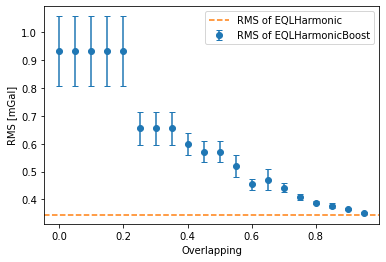

In [14]:
rms_mean = [best_parameters[o]["rms_mean"] for o in overlaps]
rms_std = [best_parameters[o]["rms_std"] for o in overlaps]

plt.errorbar(
    overlaps,
    rms_mean,
    yerr=rms_std,
    fmt="o",
    capsize=3,
    label="RMS of EQLHarmonicBoost",
)
plt.axhline(eql_rms, linestyle="--", color="C1", label="RMS of EQLHarmonic")
plt.xlabel("Overlapping")
plt.ylabel("RMS [mGal]")
plt.legend()
plt.show()

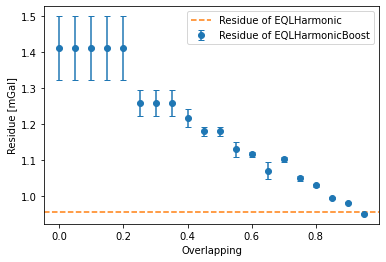

In [15]:
residue_mean = [best_parameters[o]["residue_mean"] for o in overlaps]
residue_std = [best_parameters[o]["residue_std"] for o in overlaps]

plt.errorbar(
    overlaps,
    residue_mean,
    yerr=residue_std,
    fmt="o",
    capsize=3,
    label="Residue of EQLHarmonicBoost",
)
plt.axhline(eql_residue, linestyle="--", color="C1", label="Residue of EQLHarmonic")
plt.xlabel("Overlapping")
plt.ylabel("Residue [mGal]")
plt.legend()
plt.show()

Grid data with the best set of parameters per window size and register the fitting time for each one.

In [16]:
# Define how many times each gridder will be fitted to get a statistic of fitting times
n_runs = 10
times = np.empty(n_runs)

grids = []
fitting_times = []
fitting_times_std = []
for overlapping in overlaps:
    params = best_parameters[overlapping]["params"]
    points = block_averaged_sources(coordinates, **params)
    eql = EQLHarmonicBoost(
        points=points,
        damping=params["damping"],
        window_size=params["window_size"],
        random_state=0,
    )
    eql.overlapping = overlapping

    # Register mean fitting time and its std
    for i in range(n_runs):
        start = time.time()
        eql.fit(coordinates, getattr(survey, field).values)
        end = time.time()
        times[i] = end - start

    fitting_times.append(times.mean())
    fitting_times_std.append(times.std())

    # Grid data
    grids.append(
        eql.grid(
            upward=target.height,
            region=region,
            shape=target.shape,
            data_names=["{:.2f}".format(overlapping)],
        )
    )

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


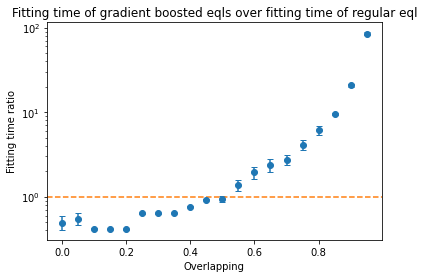

In [17]:
plt.errorbar(
    overlaps,
    np.array(fitting_times) / eql_fitting_time,
    yerr=np.array(fitting_times_std) / eql_fitting_time,
    fmt="o",
    capsize=3,
)
plt.axhline(1, linestyle="--", color="C1", label="Fitting time of EQLHarmonic")
plt.xlabel("Overlapping")
plt.ylabel("Fitting time ratio")
plt.yscale("log")
plt.title("Fitting time of gradient boosted eqls over fitting time of regular eql")
plt.show()

In [18]:
rms_relative = rms_mean / eql_rms
time_relative = np.array(fitting_times) / eql_fitting_time

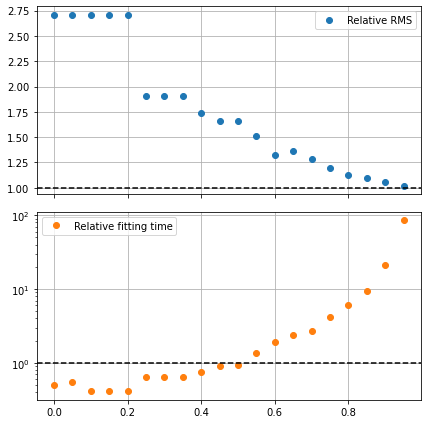

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(6, 6))

ax1.plot(overlaps, rms_relative, "o", label="Relative RMS", c="C0")
ax2.plot(overlaps, time_relative, "o", label="Relative fitting time", c="C1")
ax1.legend()
ax2.legend()
# ax2.set_ylim(-0.5, 2)
for ax in (ax1, ax2):
    ax.axhline(1, linestyle="--", color="black")
    ax.grid()
ax2.set_yscale("log")
plt.tight_layout()
plt.show()

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


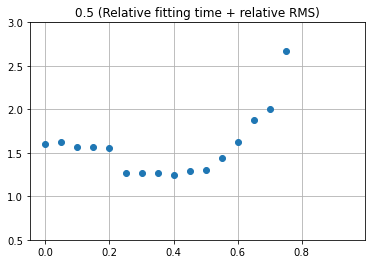

In [20]:
objective = (rms_relative + time_relative) / 2

plt.plot(overlaps, objective, "o")
plt.grid()
plt.ylim(0.5, 3)
plt.title("0.5 (Relative fitting time + relative RMS)")
plt.show()

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


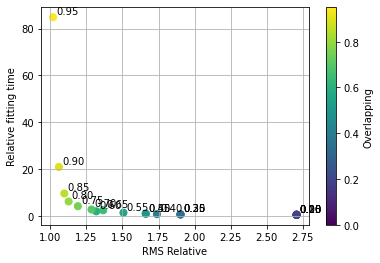

In [21]:
tmp = plt.scatter(rms_relative, time_relative, c=overlaps, s=50)
plt.grid()
plt.xlabel("RMS Relative")
plt.ylabel("Relative fitting time")
plt.colorbar(tmp, label="Overlapping")
for rms_i, fitting_i, overlapping_i in zip(rms_relative, time_relative, overlaps):
    plt.annotate(
        "{:.2f}".format(overlapping_i),
        (rms_i, fitting_i),
        xytext=(3, 3),
        xycoords="data",
        textcoords="offset points",
    )
plt.show()

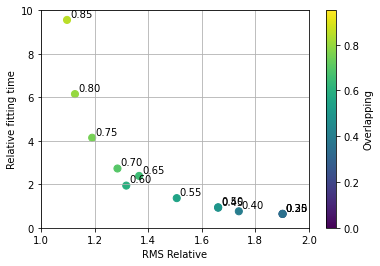

In [22]:
xlim = (1, 2)
ylim = (0, 10)

tmp = plt.scatter(rms_relative, time_relative, c=overlaps, s=50)
plt.grid()
plt.xlabel("RMS Relative")
plt.ylabel("Relative fitting time")
plt.colorbar(tmp, label="Overlapping")
plt.xlim(xlim)
plt.ylim(ylim)
for rms_i, fitting_i, overlapping_i in zip(rms_relative, time_relative, overlaps):
    if rms_i < xlim[1] and fitting_i < ylim[1]:
        plt.annotate(
            "{:.2f}".format(overlapping_i),
            (rms_i, fitting_i),
            xytext=(3, 3),
            xycoords="data",
            textcoords="offset points",
        )
plt.show()

## Dump variables dictionary to a JSON file

In [23]:
json_file = results_dir / "boost-overlapping.json"
save_to_json(variables, json_file)